# Set-up

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pickle
import itertools
from tqdm import tqdm
from collections import Counter

# Generate data / formulas

In [2]:
# ground truth data 

def all_formulae(d):
    # all feature combinations
    X = np.array(list(itertools.product(*[[0, 1]]*d)))
    
    # all possible formulae
    Y = np.array(list(itertools.product(*[[0, 1]]*(2**d)))).T
    
    return X,Y

# Calculate Shapley values explicitly

In [3]:
# shapley attributions (explicit calculations)

# coalition prediction for all formulae Y wrt example x0
def f_t(X, Y, t, x0):
    idx = np.arange(X.shape[0])
    for i in range(X.shape[1]):
        # if feature i is in coalition
        if t[i] == 1:
            # exclude incompatible feature combinations
            ix = np.where(X[idx,i] == x0[i])[0]
            idx = idx[ix]
    # average prediction of compatible combinations
    return np.mean(Y[idx],axis = 0)


# all coalitions (encoded via 0 out, 1 in) and their predictions
# T = X.copy()
# f_T = np.array([f_t(X,Y,T[i],x0) for i in range(T.shape[0])])

# combinatorial weights
def gamma(k, d):
    return math.factorial(k)*math.factorial(d-k-1)#/math.factorial(d) #(for numerical stability) 


# shapley value of feature i using coalition predictions f_T
def phi(i, X, f_T):
    T = X.copy()
    idx = np.where(T[:,i] == 0)[0]
    T_minus_i = T[idx,:]
    
    S = 0
    for j in range(T_minus_i.shape[0]):
        t = T_minus_i[j]
        t_plus_i = t.copy()
        t_plus_i[i] = 1 
        k = np.where(np.all(T == t_plus_i, axis = 1))[0]
        S = S + gamma(np.sum(t), X.shape[1]) * (f_T[k] - f_T[idx[j]])
    
    return S.reshape(-1)



# all shapley values wrt to example x0
def Phi0(X,Y,x0):
    T = X.copy()
    f_T = np.array([f_t(X,Y,T[i],x0) for i in range(T.shape[0])])
    return np.array([phi(i,X,f_T) for i in range(X.shape[1])]).T

# all shapley values 
def Phi(X,Y):
    return np.array([Phi0(X,Y,X[i]) for i in range(X.shape[0])])

def Psi(X,Y):
    return np.array([np.hstack((Y[i,:,None],Phi0(X,Y,X[i]))) for i in tqdm(range(X.shape[0]))])


# Simulations

In [4]:
# generate shapley attributions (not recommended for d > 4)
for d in [2,3,4]:
    X,Y = all_formulae(d)
    S = Psi(X,Y)
    pickle.dump(S,open(f'results/Psi_dim{d}.pkl', 'wb'))

100%|██████████| 16/16 [00:00<00:00, 19.22it/s]


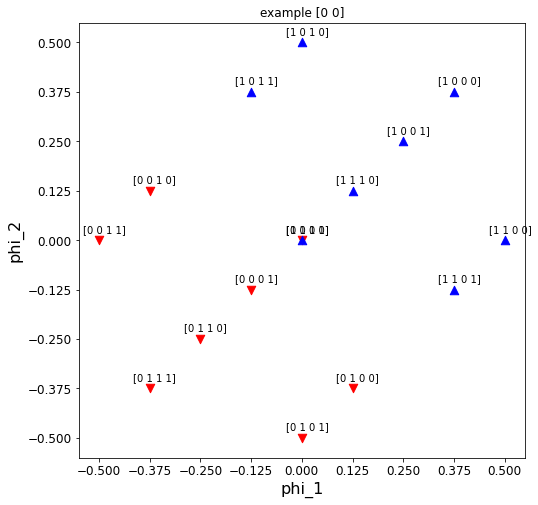

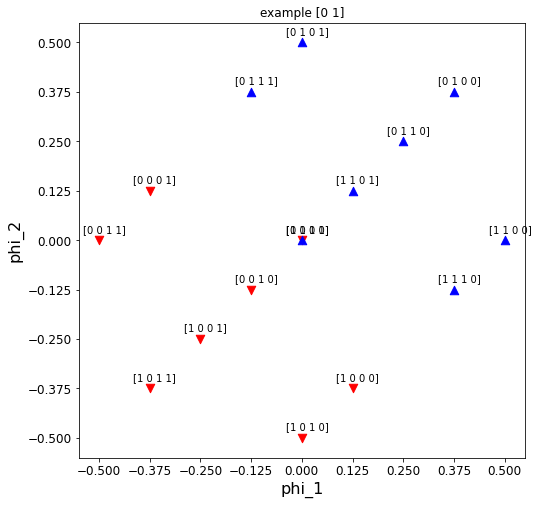

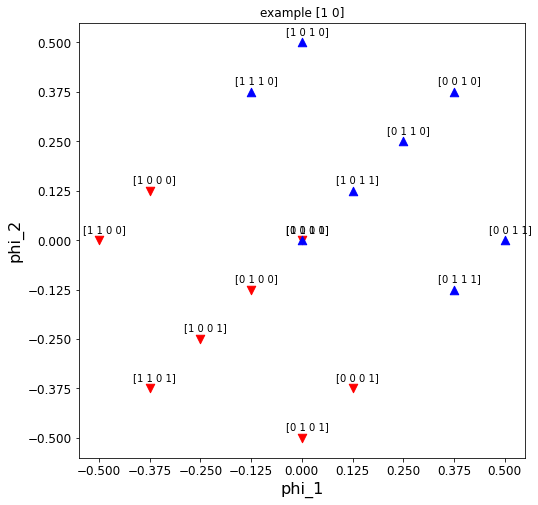

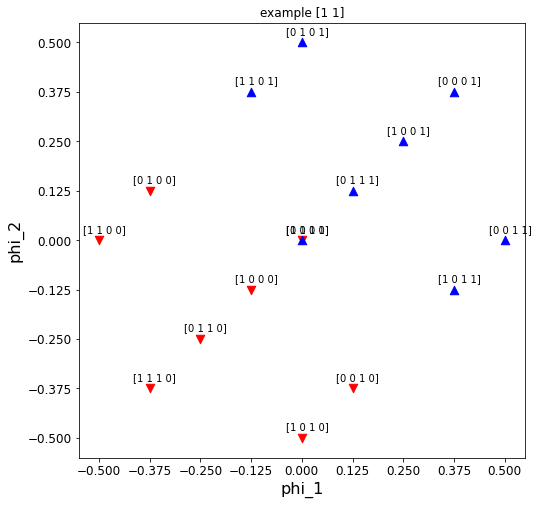

In [5]:
# figures / calculations for proof on d = 2

d = 2
X,Y = all_formulae(d)
S = Phi(X,Y)/math.factorial(d)

markers = ['v','^']
colors = ['red','blue']

for i in range(S.shape[0]):
    plt.figure(figsize=(8,8))
    
    for j in range(S.shape[1]):
        plt.scatter(*S[i,j],marker = markers[Y[i,j]], color = colors[Y[i,j]], s = 72 )
        plt.annotate(f'{Y[:,j]}', (S[i,j,0]-0.04,S[i,j,1] + 0.02))
    
    plt.xlabel('phi_1', fontsize = 16)
    plt.ylabel('phi_2', fontsize = 16)
    plt.xticks(np.linspace(-0.5,0.5,9), fontsize = 12)
    plt.yticks(np.linspace(-0.5,0.5,9), fontsize = 12)
    plt.title(f'example {X[i]}')
    plt.savefig(f'figures/phi_dim2_{i}.pdf')
    plt.show()
    

    

In [6]:
# progressive/ batched calculation (not recommended to run on your local machine for d > 4)

d = 4
X = np.array(list(itertools.product(*[[0, 1]]*d)))
Yn = 2**2**d/2

k = 256
batch_size = int(Yn // k)


In [7]:
C = Counter()
p_Nu = []
for i in tqdm(range(k)):
    yn = np.arange(batch_size*i, batch_size*(i+1))
    y = (((yn[:,None] & (1 << np.arange(2**d))[::-1])) > 0).astype(int).T 
    
    p = Phi0(X,y,X[0])
    uniq, count = np.unique(p, axis = 0, return_counts = True)

    c = Counter( dict(zip([tuple(u) for u in uniq], count)) )
    
    C = C + c
    count = np.array(list(C.values()))
    p_nu = count[count>1].sum()/(batch_size*(i+1))
    p_Nu.append(p_nu)
    print(p_nu)
    
pickle.dump(p_Nu, open(f'results/p_Nu_dim{d}_batch{i}.pkl', 'wb'))


  9%|▉         | 24/256 [00:00<00:01, 231.22it/s]

0.0
0.0
0.0625
0.09375
0.1125
0.125
0.13392857142857142
0.140625
0.1892361111111111
0.228125
0.2606534090909091
0.2877604166666667
0.2902644230769231
0.2935267857142857
0.2864583333333333
0.28125
0.2647058823529412
0.25
0.24835526315789475
0.246875
0.24404761904761904
0.24147727272727273
0.2391304347826087
0.23697916666666666
0.250625
0.26322115384615385
0.2751736111111111
0.28627232142857145
0.2874461206896552
0.2890625
0.2857862903225806
0.283203125
0.2956912878787879
0.30744485294117646
0.31741071428571427
0.3268229166666667
0.33572635135135137
0.34457236842105265


 19%|█▉        | 48/256 [00:00<00:01, 162.57it/s]

0.35076121794871795
0.35703125
0.3666158536585366
0.37611607142857145
0.3835392441860465
0.39098011363636365
0.3914930555555556
0.3958899456521739
0.3914561170212766
0.388671875
0.3989158163265306
0.40875
0.41559436274509803
0.4221754807692308
0.4267393867924528
0.4314236111111111
0.4342329545454545
0.43722098214285715
0.4428453947368421
0.44854525862068967
0.4527277542372881
0.45703125
0.4563268442622951
0.45854334677419356


 32%|███▏      | 81/256 [00:00<00:01, 114.57it/s]

0.45424107142857145
0.451171875
0.4442307692307692
0.4375
0.43423507462686567
0.43106617647058826
0.427536231884058
0.42410714285714285
0.42077464788732394
0.4175347222222222
0.422410102739726
0.42715371621621623
0.430625
0.4340049342105263
0.43262987012987014
0.43149038461538464
0.4284018987341772
0.4255859375
0.4203317901234568


 37%|███▋      | 94/256 [00:00<00:01, 97.20it/s] 

0.41520579268292684
0.41321536144578314
0.41127232142857145
0.40863970588235293
0.40606831395348836
0.4035560344827586
0.4011008522727273
0.40528441011235955
0.409375
0.41243131868131866
0.4154211956521739
0.41448252688172044
0.41373005319148937
0.41134868421052634


 41%|████      | 105/256 [00:00<00:01, 87.12it/s]

0.4091796875
0.41212951030927836
0.41501913265306123
0.41745580808080807
0.41984375
0.42218440594059403
0.42463235294117646
0.4261984223300971
0.42788461538461536
0.4310267857142857
0.4342570754716981
0.4366968457943925
0.4392361111111111
0.43900516055045874


 45%|████▍     | 115/256 [00:01<00:01, 79.20it/s]

0.44041193181818183
0.43813344594594594
0.4365234375
0.4405420353982301
0.44449013157894735
0.4472146739130435
0.44989224137931033
0.4517227564102564
0.4536546610169492
0.45476628151260506
0.45598958333333334
0.45854855371900827


 52%|█████▏    | 132/256 [00:01<00:01, 67.41it/s]

0.46170594262295084
0.4636051829268293
0.46559979838709675
0.4651875
0.4662078373015873
0.4640132874015748
0.46240234375
0.4588178294573643
0.45528846153846153
0.4534828244274809
0.45170454545454547
0.45118656015037595


 54%|█████▍    | 139/256 [00:01<00:01, 62.43it/s]

0.45067630597014924
0.44947916666666665
0.4482996323529412
0.4492472627737226
0.45018115942028986
0.4511578237410072
0.45212053571428573
0.4512411347517731
0.45048415492957744
0.4486451048951049
0.4469401041666667


 59%|█████▉    | 152/256 [00:01<00:01, 56.82it/s]

0.44385775862068966
0.4408176369863014
0.43951955782312924
0.4382390202702703
0.43786703020134227
0.4375
0.43651697019867547
0.435546875
0.43647875816993464
0.437398538961039
0.4383568548387097


 64%|██████▍   | 164/256 [00:02<00:01, 50.85it/s]

0.43930288461538464
0.43859474522292996
0.43799446202531644
0.4364190251572327
0.4349609375
0.43657802795031053
0.43817515432098764
0.43951303680981596
0.4408346036585366


 66%|██████▋   | 170/256 [00:02<00:01, 48.65it/s]

0.4421875
0.44361822289156627
0.44447043413173654
0.44540550595238093
0.4472078402366864
0.4490808823529412
0.4505208333333333
0.45203488372093026
0.4518153901734104


 70%|███████   | 180/256 [00:02<00:01, 45.50it/s]

0.45263110632183906
0.4511160714285714
0.4500177556818182
0.4525070621468927
0.4549683988764045
0.4566602653631285
0.4583333333333333
0.45951312154696133
0.4611092032967033


 74%|███████▍  | 190/256 [00:02<00:01, 42.88it/s]

0.46179132513661203
0.46255095108695654
0.46414695945945944
0.465809811827957
0.4670370989304813
0.4683344414893617
0.46804728835978837
0.46870888157894736
0.4672365837696335


 78%|███████▊  | 200/256 [00:02<00:01, 40.61it/s]

0.4661458333333333
0.4637305699481865
0.46134020618556704
0.46025641025641023
0.45918367346938777
0.45879600253807107
0.45841224747474746
0.45756124371859297
0.45671875


 80%|████████  | 205/256 [00:03<00:01, 39.35it/s]

0.45829446517412936
0.4598545792079208
0.4609759852216749
0.46208639705882354
0.46147103658536587
0.4612408980582524
0.45991847826086957
0.4586838942307692


 83%|████████▎ | 213/256 [00:03<00:01, 37.84it/s]

0.45663875598086123
0.45870535714285715
0.45801244075829384
0.4605689858490566
0.4602039319248826
0.46192318925233644
0.46111918604651164
0.4622395833333333


 86%|████████▋ | 221/256 [00:03<00:00, 35.99it/s]

0.46367367511520735
0.46577551605504586
0.4667879566210046
0.46828835227272725
0.46768947963800905
0.46772944819819817
0.4664728139013453


 89%|████████▉ | 229/256 [00:03<00:00, 34.53it/s]

0.46529715401785715
0.46631944444444445
0.46733268805309736
0.468164922907489
0.46898985745614036
0.46984170305676853
0.4707540760869565


 93%|█████████▎| 237/256 [00:04<00:00, 32.85it/s]

0.4712527056277056
0.47181438577586204
0.4730418454935622
0.47432558760683763
0.4752659574468085
0.4762645656779661
0.47600210970464135
0.47649684873949577


 96%|█████████▌| 245/256 [00:04<00:00, 31.81it/s]

0.4752876569037657
0.47438151041666665
0.47610866182572614
0.4786931818181818
0.4798418209876543
0.48187756147540983
0.4826530612244898


 97%|█████████▋| 249/256 [00:04<00:00, 31.19it/s]

0.4839303861788618
0.48434337044534415
0.48481602822580644
0.4859437751004016
0.4874375
0.488265687250996
0.4891493055555556


100%|██████████| 256/256 [00:04<00:00, 54.51it/s]

0.4888525197628458
0.48938853346456695
0.4882046568627451
0.4873046875


In [8]:
# number of non-unique explanations 
p_nus = []
ds = [2,3,4,5]
for d in ds:
    if d == 5:
        p_nu = pickle.load(open(f'results/p_Nu_dim{d}_batch16.pkl', 'rb'))[-1]
    else:
        S = pickle.load(open(f'results/Psi_dim{d}.pkl', 'rb'))
        uniq, count = np.unique(S[0], axis = 0, return_counts = True)
        nu = count[count > 1].sum()
        p_nu = nu/S.shape[1]
        
    p_nus.append(p_nu)


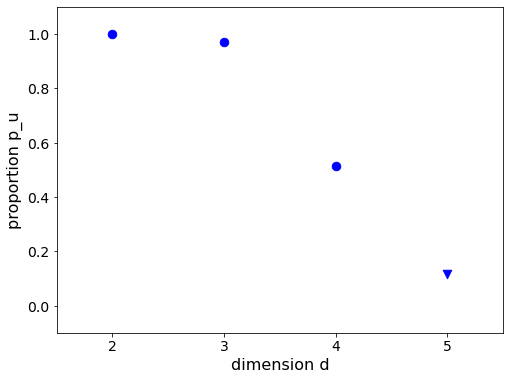

In [9]:
# plot 
plt.figure(figsize=(8, 6))

for d,p_nu,m in zip(ds,p_nus,['o','o','o','v']):
    plt.scatter(d,1-p_nu,marker=m,color = 'blue', s = 72 )

plt.xlabel('dimension d', fontsize = 16)
plt.ylabel('proportion p_u',fontsize = 16)
#plt.title('Proportion of non-unique Shapley explanations on logical formulae', fontsize = 14)
plt.xlim(1.5, 5.5)
plt.ylim(-0.1, 1.1)
plt.xticks(np.linspace(2,5,4),fontsize = 14)
plt.yticks(np.linspace(0,1,6),fontsize = 14)
plt.savefig('figures/p_nu.pdf')
plt.show()

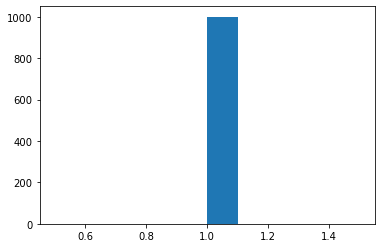

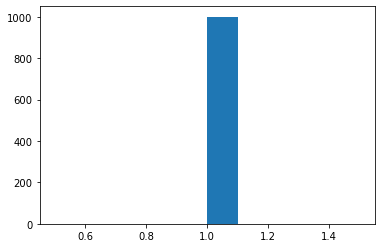

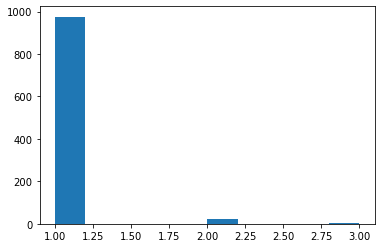

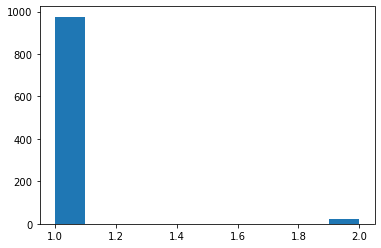

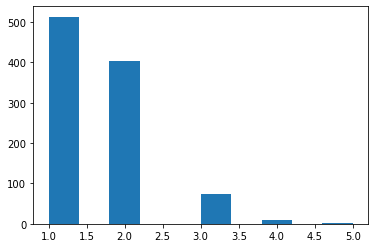

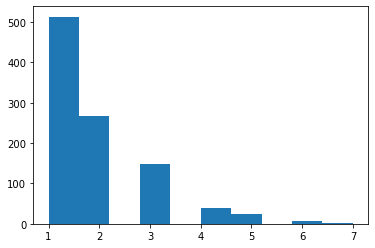

[1.0, 1.027, 1.584]
[1.0, 1.024, 1.819]


In [10]:
# number of equivalent formulas and number of examples needed to identify a formula

mean_ks = []
mean_ls = []

for d in [2,3,4]:
    S = pickle.load(open(f'results/Psi_dim{d}.pkl', 'rb'))
    
    N = 1000
    K = []
    L = []
    for i in range(N):
        k = 0
        C = np.arange(S.shape[1])
        yi = np.random.randint(0,S.shape[1])
        
        xi = np.random.permutation(np.arange(2**d))
        j = 0

        #print(yi)

        while(C.shape[0] > 1):
            idx = np.where(np.all(S[xi[j],C] == S[xi[j],yi], axis = 1))[0]
            if j == 0:
                L.append(len(idx))
            C = C[idx]
            k += 1
            j += 1

            #print(C)
        K.append(k)
        
    plt.hist(K)
    plt.show()
    
    plt.hist(L)
    plt.show()
    mean_ks.append(np.mean(K)) 
    mean_ls.append(np.mean(L))

print(mean_ks)
print(mean_ls)

In [11]:
## explore unique explanations:

d = 3
X,Y = all_formulae(d)
S = Psi(X,Y)

uniq, count = np.unique(S[0], axis = 0, return_counts = True)
nu = count[count > 1].sum()
p_nu = nu/S.shape[1]

print(p_nu)

for s in uniq[count == 2]: 
    idx = np.arange(S.shape[1])
    mask = [np.allclose(S[0,i], s) for i in idx]
    #print(mask)
    idx = idx[mask]
    
    idx = np.where(np.all(S[0] == s, axis = 1))[0]
    i=idx[0] 
    print(S[0,i,:])
    print(idx)
    print(Y[:,idx].T)

100%|██████████| 8/8 [00:00<00:00, 1160.93it/s]

0.03125
[ 0. -1. -1. -1.]
[ 23 105]
[[0 0 0 1 0 1 1 1]
 [0 1 1 0 1 0 0 1]]
[ 0.   -0.75 -0.75 -0.75]
[ 22 104]
[[0 0 0 1 0 1 1 0]
 [0 1 1 0 1 0 0 0]]
[1.   0.75 0.75 0.75]
[151 233]
[[1 0 0 1 0 1 1 1]
 [1 1 1 0 1 0 0 1]]
[1. 1. 1. 1.]
[150 232]
[[1 0 0 1 0 1 1 0]
 [1 1 1 0 1 0 0 0]]
